<a href="https://colab.research.google.com/github/fjgr/IA_BigData/blob/main/M2D/Tarea-7/TAREA8__MODELOS_DE_PYTHON_A_TENSORFLOW_JS-(Flores).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de clasificación de imágenes con MobileNetV2 + TensorFlow.js

## Introducción

En este cuaderno, construiremos y entrenaremos un modelo de clasificación de imágenes utilizando **MobileNetV2** como base mediante **Transfer Learning**.  
Posteriormente, exportaremos el modelo para ser usado en aplicaciones web con **TensorFlow.js**.

### Objetivo

1. Importación de Bibliotecas
2. Definición de Parámetros Generales
3. Creación del Modelo
4. Preparación de Generadores de Datos
5. Entrenamiento del Modelo
6. Guardado de Pesos y Exportación a TensorFlow.js

**Versiones de librerías utilizadas:**
- TensorFlow: `2.11.0`
- TensorFlow.js: `3.18.0`
- NumPy: `1.23.5`


## 1. Importación de Bibliotecas

En esta sección, importaremos todas las bibliotecas necesarias para construir, entrenar y exportar nuestro modelo.

In [ ]:
# Importar TensorFlow y los módulos necesarios para crear y entrenar el modelo
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models, optimizers

# Importar módulo para gestionar rutas de archivos
import pathlib

# Importar librería NumPy para operaciones numéricas
import numpy as np

# Importar Matplotlib para la visualización de datos
import matplotlib.pyplot as plt

# Importar ImageDataGenerator para la preparación de datos con aumento de imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Verificar versiones
print(f"TensorFlow versión: {tf.__version__}")
print("TensorFlow.js versión:", tfjs.__version__)
print(f"NumPy versión: {np.__version__}")

TensorFlow versión: 2.11.0
TensorFlow.js versión: 3.18.0
NumPy versión: 1.23.5


## 2. Definición de Parámetros Generales

A continuación, se definen los parámetros principales que se utilizarán en la construcción y entrenamiento del modelo:

- `IMG_HEIGHT` y `IMG_WIDTH`: Dimensiones a las que se redimensionarán todas las imágenes de entrada.
- `BATCH_SIZE`: Número de imágenes que se procesarán juntas en cada paso de entrenamiento.
- `NUM_CLASSES`: Número de clases o categorías que el modelo debe predecir.
- `EPOCHS`: Número total de épocas (pasadas completas sobre el conjunto de datos) para entrenar el modelo.
- `LEARNING_RATE`: Tasa de aprendizaje utilizada por el optimizador.
- `VALIDATION_SPLIT`: Proporción del conjunto de datos que se utilizará para validación.
- `RANDOM_STATE`: Semilla para garantizar la reproducibilidad de los resultados.

También se definen las rutas necesarias:

- `DATA_DIR`: Ruta donde se encuentran las imágenes para entrenamiento y validación.
- `WEIGHTS_PATH`: Ruta donde se guardarán los pesos del mejor modelo entrenado.
- `EXPORT_DIR`: Ruta donde se exportará el modelo completo para su uso en TensorFlow.js.


In [ ]:
# Definición de parámetros generales

IMG_HEIGHT = 224  # Altura de las imágenes de entrada
IMG_WIDTH = 224   # Ancho de las imágenes de entrada
BATCH_SIZE = 16   # Número de imágenes por lote
NUM_CLASSES = 5   # Número de clases en el conjunto de datos
EPOCHS = 30       # Número de épocas para entrenar el modelo
LEARNING_RATE = 0.0001  # Tasa de aprendizaje para el optimizador
VALIDATION_SPLIT = 0.2  # Porcentaje del conjunto de datos utilizado para validación
RANDOM_STATE = 42       # Semilla aleatoria para reproducibilidad

# Definición de rutas
DATA_DIR = pathlib.Path('dataset')                  # Ruta principal del dataset
TRAIN_DIR = DATA_DIR / 'train'                      # Ruta al directorio de entrenamiento
TEST_DIR = DATA_DIR / 'test'                        # Ruta al directorio de test
WEIGHTS_PATH = "best_model_mobilenetv2.weights.h5"  # Ruta para guardar los pesos del mejor modelo
EXPORT_DIR = "modelo_saved_mobilenetv2"             # Ruta para exportar el modelo completo para TensorFlow.js

# Verificamos que los directorios existan
print(f"Directorio de entrenamiento: {TRAIN_DIR}")
print(f"Directorio de prueba: {TEST_DIR}")

Directorio de entrenamiento: dataset\train
Directorio de prueba: dataset\test


## 3. Exploración del Dataset

Antes de entrenar el modelo, realizamos una breve exploración del dataset para entender mejor la distribución de las imágenes entre las diferentes categorías de flores.

Esto nos ayudará a verificar si las clases están equilibradas o si existe algún desbalance que deba ser tenido en cuenta durante el entrenamiento.


Categorías de flores: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Categoría 'daisy': 501 imágenes
Categoría 'dandelion': 646 imágenes
Categoría 'rose': 497 imágenes
Categoría 'sunflower': 495 imágenes
Categoría 'tulip': 607 imágenes


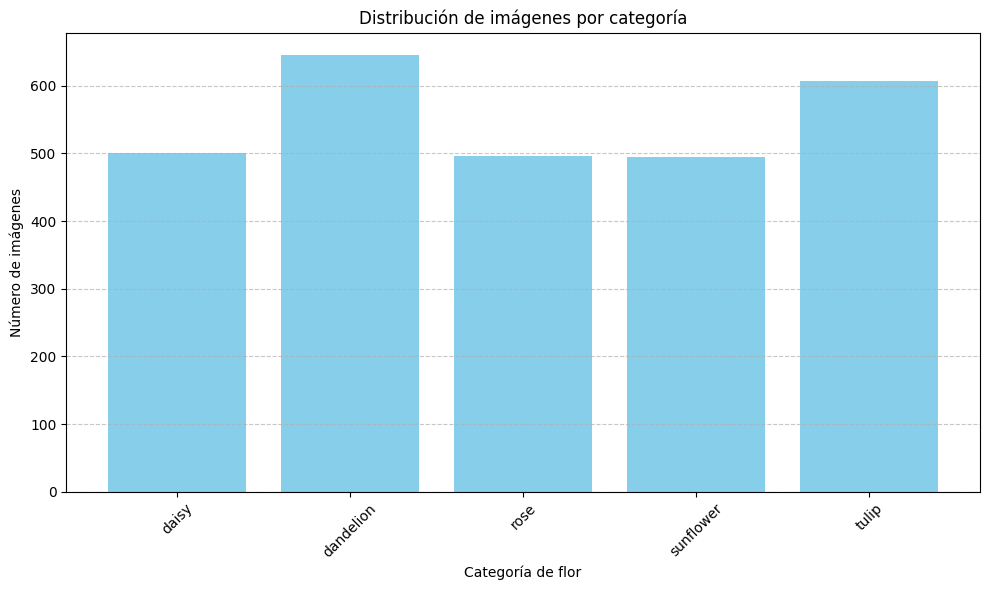

In [ ]:
# Obtenemos las clases (categorías de flores) del directorio de entrenamiento
class_names = sorted([item.name for item in TRAIN_DIR.glob('*') if item.is_dir()])
print(f"Categorías de flores: {class_names}")

# Contamos el número de imágenes por categoría
class_counts = {}
for class_name in class_names:
    num_images = len(list(TRAIN_DIR.glob(f'{class_name}/*.jpg')))
    class_counts[class_name] = num_images
    print(f"Categoría '{class_name}': {num_images} imágenes")

# Visualizamos la distribución de imágenes por categoría
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Distribución de imágenes por categoría')
plt.xlabel('Categoría de flor')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


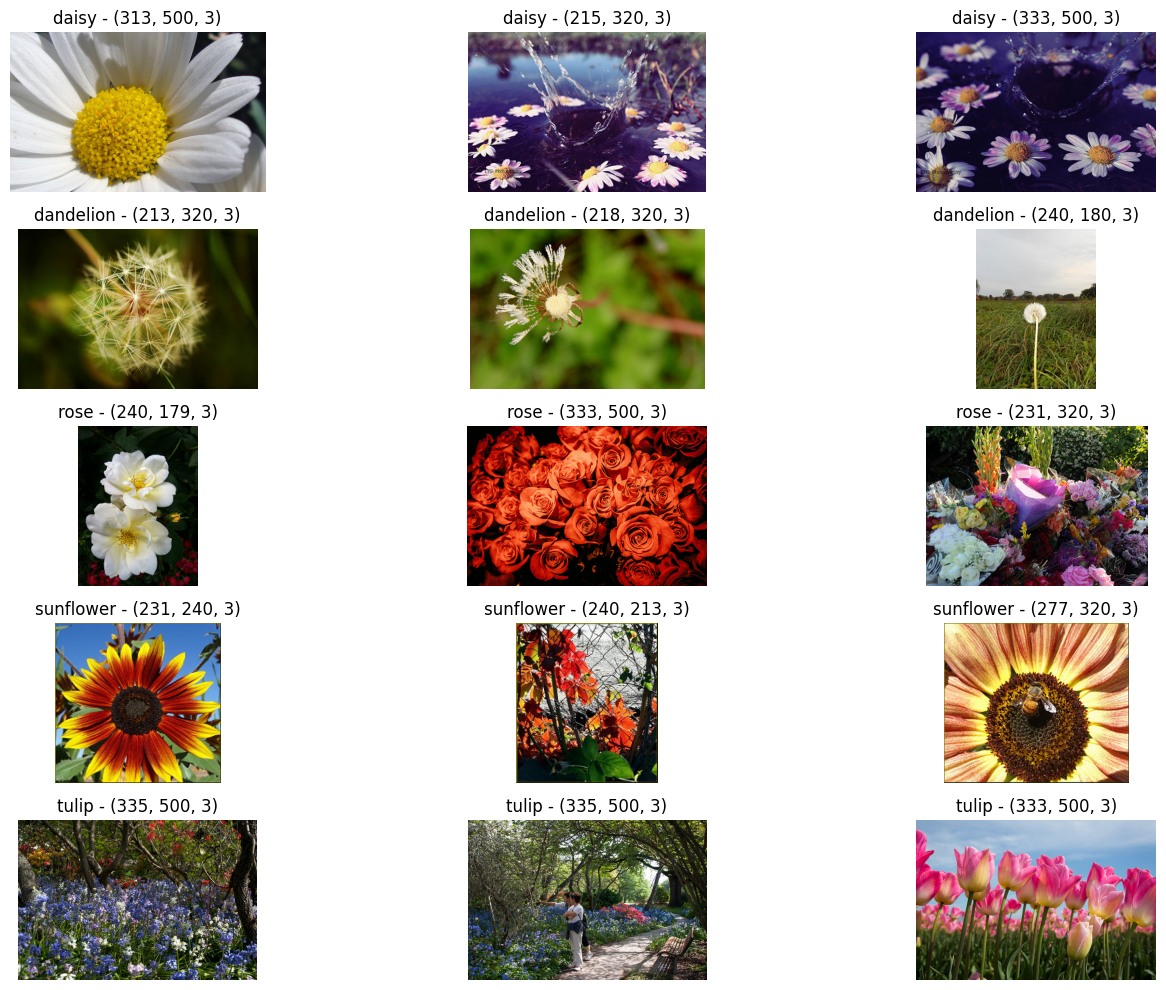

In [ ]:
# Visualizamos algunas imágenes de ejemplo
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    # Obtenemos 3 imágenes aleatorias de cada categoría
    images = list(TRAIN_DIR.glob(f'{class_name}/*.jpg'))[:3]
    for j, img_path in enumerate(images):
        img = plt.imread(img_path)
        plt.subplot(5, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f"{class_name} - {img.shape}")
        plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Preparación de los Datos con Estratificación

En esta sección, preparamos los datos para el entrenamiento del modelo utilizando generadores de imágenes.

- Para el conjunto de **entrenamiento** aplicaremos técnicas de **aumentación de datos** para mejorar la capacidad de generalización del modelo.
- Para el conjunto de **validación**, solo aplicaremos el preprocesamiento necesario, sin aumentación, para evaluar correctamente el rendimiento.

Utilizaremos un **20% de los datos** para la validación, asegurando una **estratificación** basada en las categorías (manteniendo la distribución original).


In [ ]:
# Generador para el conjunto de entrenamiento con aumentación de datos

train_datagen = ImageDataGenerator(
    rescale=1./127.5,  # Normalizar imágenes a rango [-1, 1]
    preprocessing_function=lambda x: x - 1,
    validation_split=0.2,  # 20% de validación
    rotation_range=20,     # Rotaciones aleatorias
    width_shift_range=0.2, # Desplazamiento horizontal
    height_shift_range=0.2,# Desplazamiento vertical
    shear_range=0.2,       # Cizallamiento
    zoom_range=0.2,        # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
    fill_mode='nearest'    # Rellenar huecos
)

# Generador para el conjunto de validación (solo preprocesamiento)
validation_datagen = ImageDataGenerator(
    rescale=1./127.5,
    preprocessing_function=lambda x: x - 1,
    validation_split=0.2
)

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=RANDOM_STATE
)

# Cargar imágenes de validación
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=RANDOM_STATE
)

# Verificamos las clases y su mapeo a índices
print("\nMapeo de clases a índices:")
for class_name, class_idx in train_generator.class_indices.items():
    print(f"{class_name}: {class_idx}")

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.

Mapeo de clases a índices:
daisy: 0
dandelion: 1
rose: 2
sunflower: 3
tulip: 4


## 5. Visualización de Datos Aumentados

Visualizamos algunos ejemplos de imágenes aumentadas para entender cómo funciona la aumentación de datos.

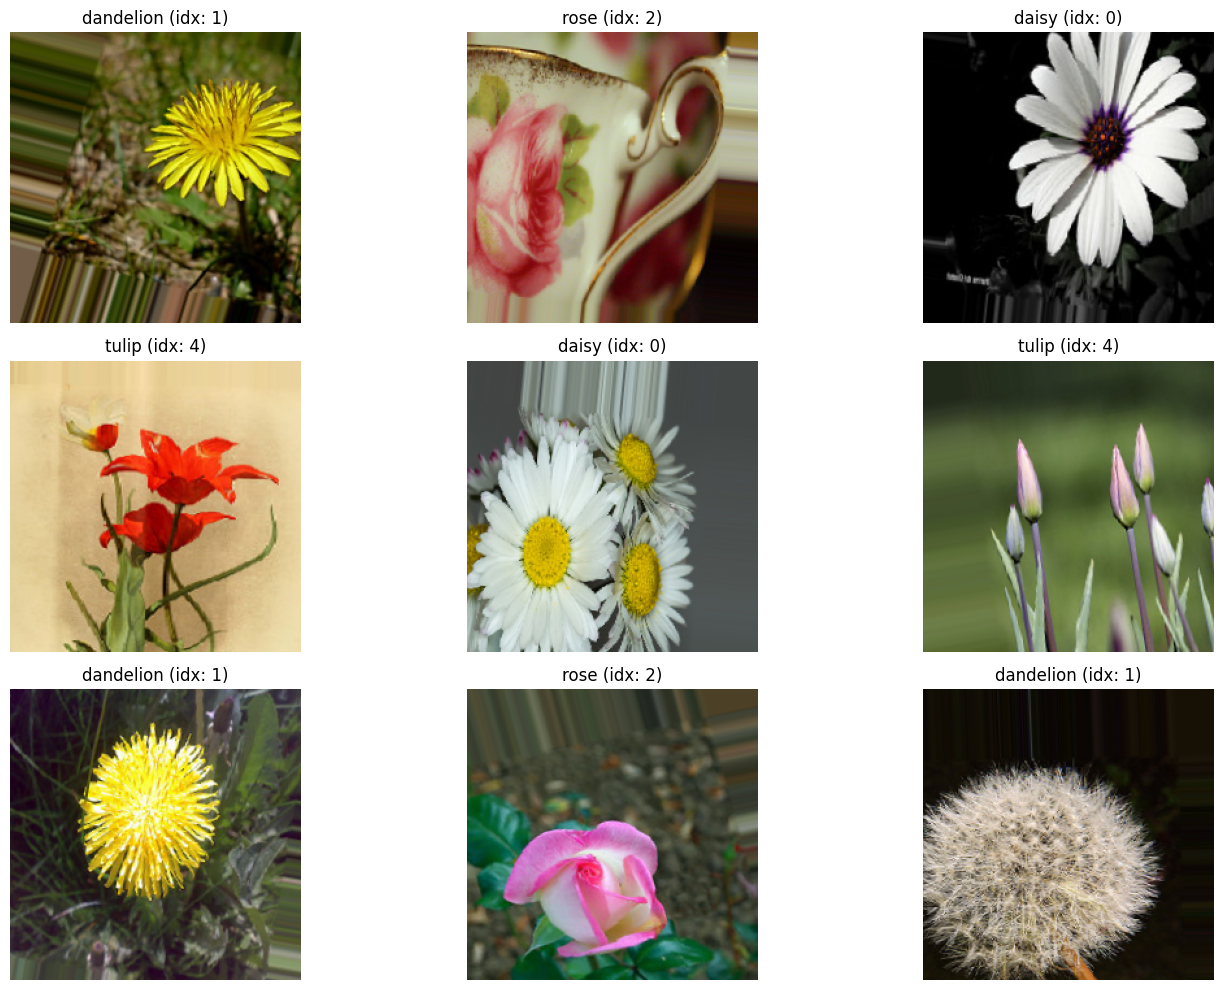

In [ ]:
# Obtenemos un lote de imágenes y etiquetas
images, labels = next(train_generator)

# Convertimos las imágenes de vuelta al rango [0, 1] para visualización
def convert_for_display(img):
    # Deshacemos el preprocesamiento para visualización
    img = img.copy()
    img = img - img.min()
    img = img / img.max()
    return img

# Visualizamos algunas imágenes aumentadas
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img_for_display = convert_for_display(images[i])
    plt.imshow(img_for_display)
    # Convertimos el one-hot encoding a índice de clase
    label_idx = np.argmax(labels[i])
    plt.title(f"{class_names[label_idx]} (idx: {label_idx})")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 6. Creación del Modelo **MobileNetV2**

En esta sección, crearemos un modelo basado en la arquitectura **MobileNetV2**, preentrenada en **ImageNet**, utilizando la técnica de **Transfer Learning**.

- **MobileNetV2** se utilizará como **feature extractor** (extracción de características) congelado inicialmente.
- Añadiremos capas densas adicionales para adaptar el modelo a nuestra tarea de clasificación de 5 categorías de flores.
- Utilizaremos funciones de activación **ReLU** y la última capa con **softmax** para predicción multiclase.
- Compilaremos el modelo usando el optimizador **Adam** con una tasa de aprendizaje ajustada.

El objetivo es construir un modelo eficiente y robusto, minimizando el riesgo de sobreajuste.


In [ ]:
# Definimos la arquitectura del modelo basado en MobileNetV2 preentrenado en ImageNet

def create_mobilenetv2_model():

    # Cargar la base MobileNetV2 sin la capa superior (sin clasificador final)
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',    # Pesos preentrenados en ImageNet
        include_top=False,     # No incluir la última capa densa
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False  # Congelar pesos de la base inicialmente (Transfer Learning)

    # Definir la nueva arquitectura
    inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    # Compilar el modelo
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Creamos el modelo
model = create_mobilenetv2_model()

# Mostramos un resumen del modelo
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328

## 7. Entrenamiento del Modelo

En esta sección, entrenamos el modelo creado utilizando los generadores de datos previamente definidos:

- Usamos un número de **épocas** establecido para optimizar el rendimiento.
- Se monitoriza tanto la **pérdida** como la **precisión** en los conjuntos de entrenamiento y validación.
- Se recoge el historial de entrenamiento para su posterior análisis gráfico.

Además, configuramos dos callbacks importantes:

- **EarlyStopping**: Detiene el entrenamiento si la pérdida de validación (`val_loss`) no mejora después de 5 épocas consecutivas. Esto ayuda a evitar el sobreajuste y a optimizar el tiempo de entrenamiento.
- **ModelCheckpoint**: Guarda automáticamente los mejores pesos del modelo (los de menor pérdida de validación) durante el proceso de entrenamiento.

Se utiliza la función `model.fit` pasando tanto el conjunto de entrenamiento como de validación.



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks

# EarlyStopping para detener el entrenamiento si no mejora la validación
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint para guardar los mejores pesos
checkpoint = ModelCheckpoint(
    WEIGHTS_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Entrenar el modelo

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

print("Entrenamiento completado.")


Epoch 1/30
138/138 [==============================] - ETA: 0s - loss: 1.3028 - accuracy: 0.4864
Epoch 1: val_loss improved from inf to 0.75725, saving model to best_model_mobilenetv2.weights.h5
138/138 [==============================] - 39s 252ms/step - loss: 1.3028 - accuracy: 0.4864 - val_loss: 0.7573 - val_accuracy: 0.7518
Epoch 2/30
138/138 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.6847
Epoch 2: val_loss improved from 0.75725 to 0.56727, saving model to best_model_mobilenetv2.weights.h5
138/138 [==============================] - 33s 234ms/step - loss: 0.8260 - accuracy: 0.6847 - val_loss: 0.5673 - val_accuracy: 0.8029
Epoch 3/30
138/138 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7461
Epoch 3: val_loss improved from 0.56727 to 0.50418, saving model to best_model_mobilenetv2.weights.h5
138/138 [==============================] - 33s 236ms/step - loss: 0.6692 - accuracy: 0.7461 - val_loss: 0.5042 - val_accuracy: 0.8102
Epoch 4/

## 8. Visualización de Resultados del Entrenamiento

Después de entrenar el modelo, es muy útil visualizar las métricas de entrenamiento para analizar su comportamiento.

Mostramos dos gráficas:

- **Accuracy**: Precisión tanto en entrenamiento como en validación.
- **Loss**: Pérdida tanto en entrenamiento como en validación.

Estas gráficas ayudan a detectar posibles problemas como **overfitting** o **underfitting**.

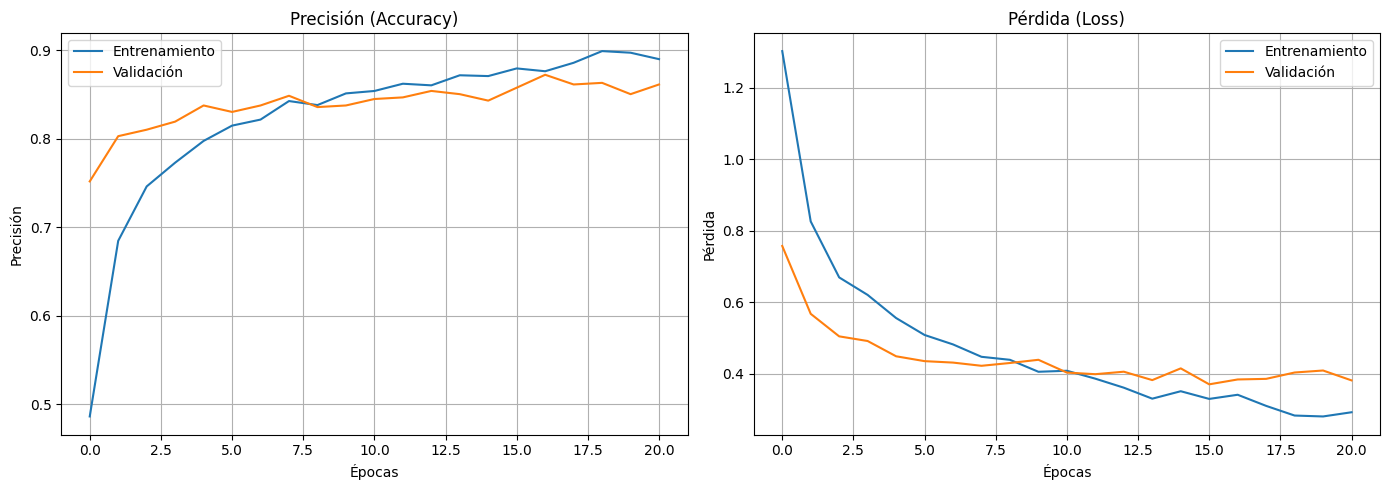

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualizamos las curvas de precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Gráfica de Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Gráfica de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Guardamos la gráfica
plt.savefig('resultados_entrenamiento_final.png')

In [ ]:
# Identificamos la mejor época basada en la precisión de validación
best_epoch = np.argmax(val_acc)
best_val_accuracy = val_acc[best_epoch]

print(f"Mejor precisión de validación: {best_val_accuracy:.4f} en la época {best_epoch+1}")

Mejor precisión de validación: 0.8723 en la época 17


## 9. Evaluación Detallada del Modelo

Evaluamos el rendimiento del modelo en el conjunto de validación con métricas detalladas.

Esto nos permite analizar el rendimiento del modelo en cada categoría de flores individualmente.


In [ ]:
from sklearn.metrics import classification_report

# Evaluación detallada

# Obtenemos las predicciones del modelo
validation_generator.reset()  # Reseteamos el generador
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Verdaderas clases
true_classes = validation_generator.classes

# Nombres de las clases
class_labels = list(validation_generator.class_indices.keys())

# Generamos el informe de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4)
print("📄 Informe de Clasificación:\n")
print(report)

# Guardamos el informe de clasificación en un archivo
with open('classification_report.txt', 'w') as f:
    f.write(report)

35/35 [==============================] - 7s 169ms/step
📄 Informe de Clasificación:

              precision    recall  f1-score   support

       daisy     0.8529    0.8700    0.8614       100
   dandelion     0.8917    0.8295    0.8594       129
        rose     0.8646    0.8384    0.8513        99
   sunflower     0.8687    0.8687    0.8687        99
       tulip     0.8168    0.8843    0.8492       121

    accuracy                         0.8577       548
   macro avg     0.8589    0.8582    0.8580       548
weighted avg     0.8590    0.8577    0.8577       548



### Matriz de Confusión

La matriz de confusión permite visualizar el rendimiento del modelo al comparar las predicciones con las etiquetas reales.

Cada fila representa la instancia real y cada columna la instancia predicha.  
Idealmente, los valores altos deben estar en la diagonal principal.


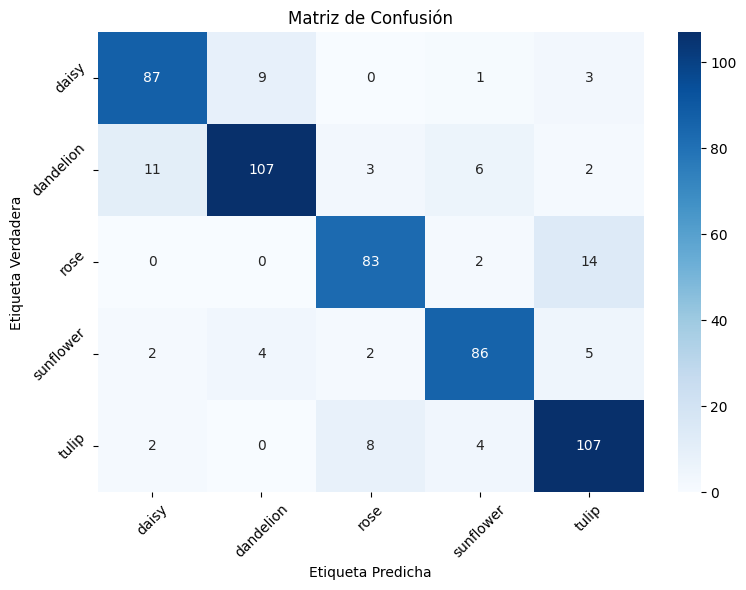

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizamos la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Guardamos la matriz de confusión
plt.savefig('matriz_confusion_final.png')

## 10. Visualización de Predicciones

En esta sección, seleccionamos aleatoriamente algunas imágenes del conjunto de validación para observar el desempeño del modelo.

Cada imagen muestra:

- **Real:** La etiqueta real de la imagen.
- **Pred:** La predicción del modelo junto con el porcentaje de confianza.

El color del texto será:

- **Verde:** Si la predicción es correcta.
- **Rojo:** Si la predicción es incorrecta.

Esto nos permite evaluar visualmente la precisión y la seguridad de las predicciones realizadas por nuestro modelo.


1/1 [==============================] - 0s 59ms/step


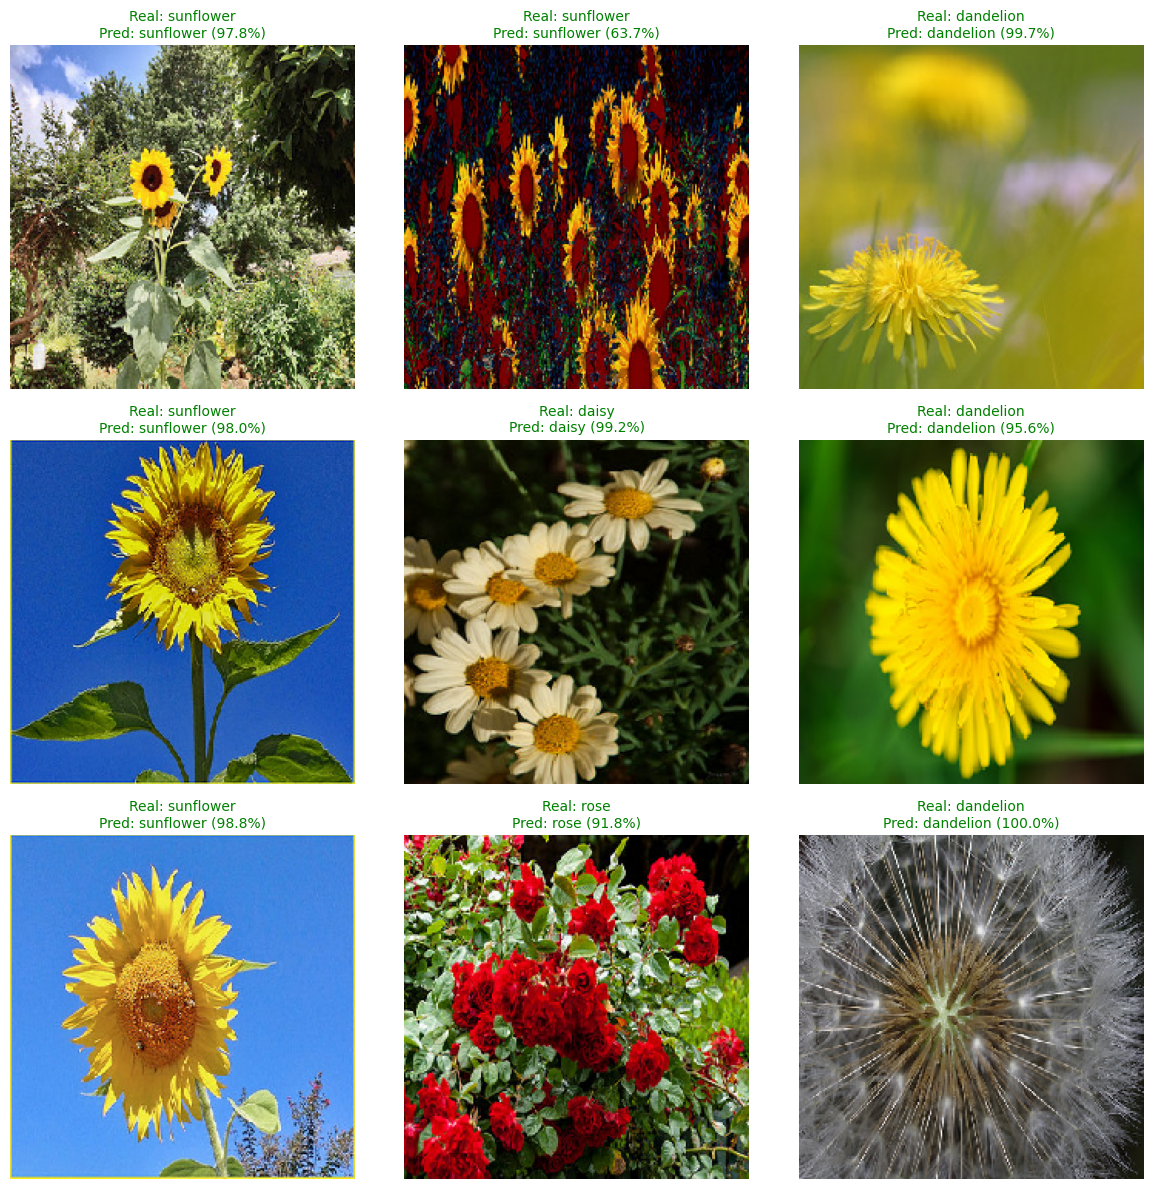

<Figure size 640x480 with 0 Axes>

In [ ]:
import random

# Tomamos algunas muestras aleatorias del conjunto de validación
num_images = 9
indices = random.sample(range(len(validation_generator.filenames)), num_images)
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    img_path = validation_generator.filepaths[idx]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 127.5 - 1.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    pred_idx = np.argmax(predictions)
    true_idx = validation_generator.classes[idx]

    pred_label = class_names[pred_idx]
    true_label = class_names[true_idx]
    confidence = np.max(predictions)

    color = 'green' if pred_label == true_label else 'red'

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Real: {true_label}\nPred: {pred_label} ({confidence*100:.1f}%)", color=color, fontsize=10)

plt.tight_layout()
plt.show()

# Guardamos la visualización
plt.savefig('predicciones_final.png')

## 11. Guardado del Modelo

Una vez que el modelo ha sido entrenado y evaluado satisfactoriamente, procedemos a guardar:

- **Los mejores pesos** obtenidos durante el entrenamiento (gracias a `ModelCheckpoint`).
- **El modelo completo**, incluyendo su arquitectura, pesos y configuración de entrenamiento.

Este proceso es esencial para reutilizar el modelo sin necesidad de volver a entrenarlo, permitiendo su carga directa para futuras inferencias o exportaciones.

Guardaremos los pesos en formato `.h5` y el modelo completo en formato de `SavedModel` para su posible conversión a TensorFlow.js o despliegue en producción.


In [ ]:
# Guardamos los mejores pesos
model.load_weights(WEIGHTS_PATH)  # Nos aseguramos de cargar los mejores pesos
print("✅ Mejores pesos cargados.")

# Guardamos el modelo completo en formato SavedModel
tf.saved_model.save(model, EXPORT_DIR)
print(f"✅ Modelo completo guardado en {EXPORT_DIR}")

✅ Mejores pesos cargados.


INFO:tensorflow:Assets written to: modelo_saved_mobilenetv2\assets


INFO:tensorflow:Assets written to: modelo_saved_mobilenetv2\assets


✅ Modelo completo guardado en modelo_saved_mobilenetv2


## 12. Exportación a TensorFlow.js

Una vez entrenado y guardado nuestro modelo en formato SavedModel, lo convertiremos al formato compatible con TensorFlow.js para poder desplegarlo en aplicaciones web.  
Utilizaremos la herramienta `tensorflowjs_converter` para realizar la conversión.

In [ ]:
# Convertimos el modelo guardado al formato de TensorFlow.js
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='Identity' --saved_model_tags=serve {EXPORT_DIR} tfjs_model

print("✅ Conversión a TensorFlow.js completada.")


Writing weight file tfjs_model\model.json...
✅ Conversión a TensorFlow.js completada.
